# Import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import difflib

import nltk
from nltk.corpus import stopwords

import numpy as np
from scipy import stats
import nltk
nltk.download('stopwords')
import spacy

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.over_sampling import SMOTE

In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning

# Reading data

In [ ]:
df1 = pd.read_excel('DDS10_Data_Extract_with_labels.xlsx')
df2 = pd.read_excel('DDS11_Data_Extract_with_labels.xlsx')

In [ ]:
df1.shape

(2205, 197)

In [ ]:
df2.shape

(2131, 198)

In [ ]:
df_combined = pd.concat([df1, df2], axis=0)
df_combined.columns = pd.read_excel('Column Names.xlsx')['New']
df_combined.drop('ID',axis=1,inplace=True)
df_combined.shape

(4336, 197)

# Basic correlation checks

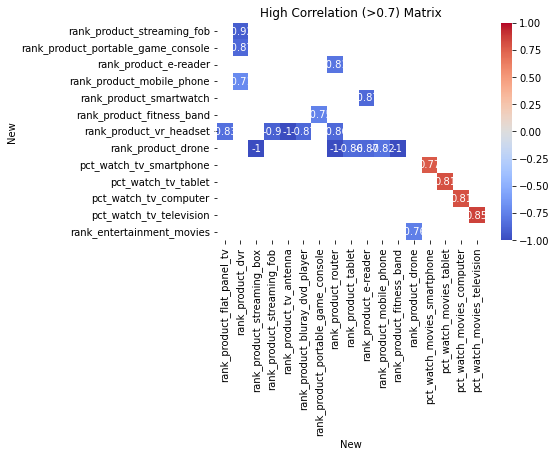

In [ ]:
corr = df_combined.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
corr_high = corr.mask(mask)  # mask out the upper triangle of the correlation matrix
corr_high = corr_high[abs(corr_high) > 0.7].dropna(how='all', axis=1).dropna(how='all', axis=0) # select only high correlations > 0.7

sns.heatmap(corr_high, cmap='coolwarm', annot=True, vmin=-1, vmax=1)
plt.title('High Correlation (>0.7) Matrix')
plt.show()


# Data Preprocessing

## Drop columns with more than 95% missing data

In [ ]:
# Drop columns with more than 95% missing data
df_combined = df_combined.dropna(thresh=0.95 * len(df_combined), axis=1)
df_combined.shape

(4336, 111)

In [ ]:
df_combined.select_dtypes(exclude='number').shape

(4336, 97)

## NaN & outlier treatment for Numeric columns

In [ ]:
# Replace missing values with mean of each column for numeric columns
df_combined[df_combined.select_dtypes(include='number').columns] = df_combined.select_dtypes(include='number').fillna(df_combined.mean)

# Select only numeric columns
numeric_cols = df_combined.select_dtypes(include='number').columns

# Remove outliers using z-score method
z_scores = np.abs(stats.zscore(df_combined[numeric_cols]))
threshold = 4
data_no_outliers_numeric = df_combined[numeric_cols][(z_scores < threshold).all(axis=1)]
data_no_outliers_numeric.shape


/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


(4019, 14)

In [ ]:
data_no_outliers_numeric = data_no_outliers_numeric.reset_index(drop=True)
df_combined_nonnumeric = df_combined.select_dtypes(exclude='number').reset_index(drop=True)
df_combined = pd.merge(data_no_outliers_numeric, df_combined_nonnumeric, left_index=True, right_index=True)
df_combined.shape

(4019, 111)

## categorical coulms encoding

<ipython-input-18-569749b3a3f8>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  pct_region_tv = df_combined.groupby('region')['pct_watch_tv_smartphone',


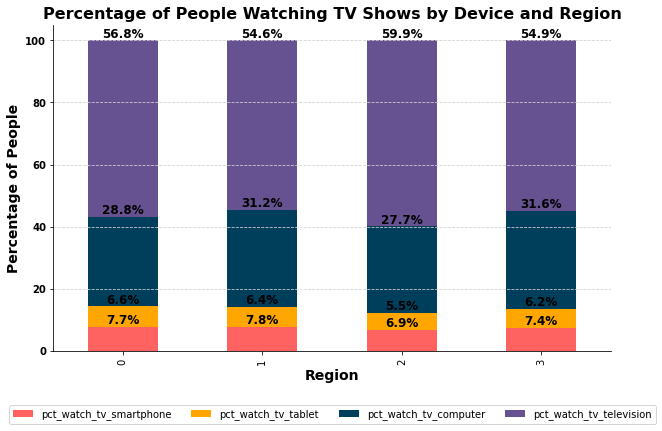

In [ ]:
# Define cool colors
cool_colors = ['#ff6361', '#ffa600', '#003f5c', '#665191']


pct_region_tv = df_combined.groupby('region')['pct_watch_tv_smartphone',
'pct_watch_tv_tablet',
'pct_watch_tv_computer',
'pct_watch_tv_television'].mean()

pct_region_totals_pct = pct_region_tv.apply(lambda x: x/x.sum(), axis=1) * 100

# Plot the stacked bar chart
ax = pct_region_totals_pct.plot(kind='bar', stacked=True, figsize=(10,6), color=cool_colors)

# Add percentage labels to each bar
for i in ax.containers:
    ax.bar_label(i, labels=[f"{val:.1f}%" if val > 0 else "" for val in i.datavalues], label_type='edge', fontsize=12, fontweight='bold')

# Add labels and title
plt.xlabel('Region', fontsize=14, fontweight='bold')
plt.ylabel('Percentage of People', fontsize=14, fontweight='bold')
plt.title('Percentage of People Watching TV Shows by Device and Region', fontsize=16, fontweight='bold')

# Move the legend below the plot
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)

# Beautify the graph
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.grid(color='lightgray', linestyle='dashed')

# Set y-axis tick labels to bold
plt.yticks(fontweight='bold')

# Show the plot
plt.show()

In [ ]:
# Define a dictionary to store the mapping of unique values to encoded values
encoding_dict = {}

# Loop through each non-numeric column in the dataframe
for col in df_combined.select_dtypes(exclude='number').columns:

    # Get all unique values in the column
    unique_values = df_combined[col].unique()

    # Create a mapping of unique values to encoded values
    encoding_dict[col] = {val: i for i, val in enumerate(unique_values)}

    # Replace each value in the column with its encoded value
    df_combined[col] = df_combined[col].map(encoding_dict[col])

In [ ]:
# Fill missing values in 'children' column with 0
df_combined['children'] = df_combined['children'].fillna(0)

# Fill missing values in other columns with the column mean or mode
df_combined['age'] = df_combined['age'].fillna(df_combined['age'].mode()[0])
df_combined['gender'] = df_combined['gender'].fillna(df_combined['gender'].mode()[0])
df_combined['employment_status'] = df_combined['employment_status'].fillna(df_combined['employment_status'].mode()[0])
df_combined['ethnicity'] = df_combined['ethnicity'].fillna(df_combined['ethnicity'].mode()[0])
df_combined['income'] = df_combined['income'].fillna(df_combined['income'].mode()[0])

X = df_combined.copy()
df1 = df_combined.copy()
df2 = df_combined.copy()

# Check for missing values
sorted(df_combined.isnull().sum().items(), key=lambda x: x[1], reverse=True)[:3]



[('age', 0),
 ('pct_watch_movies_smartphone', 0),
 ('pct_watch_movies_tablet', 0)]

# EDA

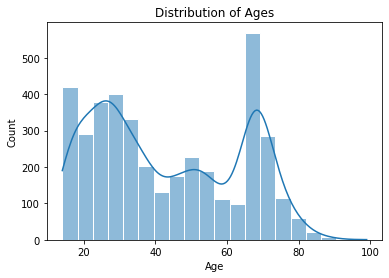

In [ ]:
# visualize the distribution of ages
sns.histplot(data=df_combined, x='age', kde=True, bins=20, edgecolor='white') # Create the histogram

# Add labels and a title
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Distribution of Ages')
plt.show()

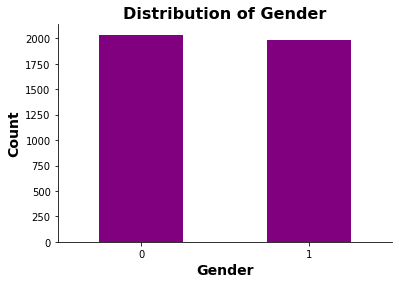

In [ ]:
df_combined['gender'].value_counts().plot(kind='bar', color='purple')

# Set the title, x-axis label, and y-axis label of the plot
plt.title('Distribution of Gender', fontsize=16, fontweight='bold')
plt.xlabel('Gender', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')

# Rotate the x-axis labels by 0 degrees to avoid overlap
plt.xticks(rotation=0)

# Remove the top and right spines
sns.despine()

# Show the plot
plt.show()


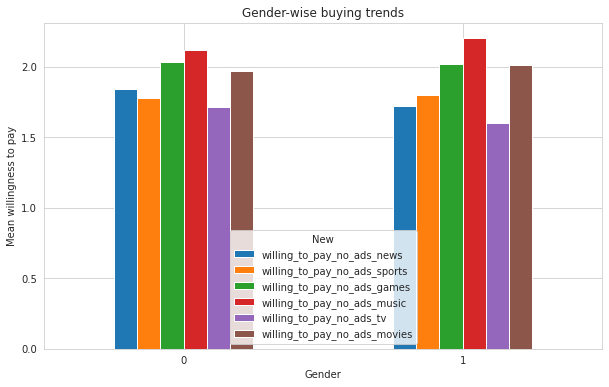

In [ ]:
# Group data by gender and calculate mean of columns related to willingness to pay
willingness_to_pay_cols = ['willing_to_pay_no_ads_news', 'willing_to_pay_no_ads_sports',
                           'willing_to_pay_no_ads_games', 'willing_to_pay_no_ads_music',
                           'willing_to_pay_no_ads_tv', 'willing_to_pay_no_ads_movies']
buying_trends = df_combined.groupby('gender')[willingness_to_pay_cols].mean()

# Plot bar chart
sns.set_style("whitegrid")
ax = buying_trends.plot(kind='bar', figsize=(10, 6))
ax.set_xlabel('Gender')
ax.set_ylabel('Mean willingness to pay')
ax.set_title('Gender-wise buying trends')
plt.xticks(rotation=0)
plt.show()

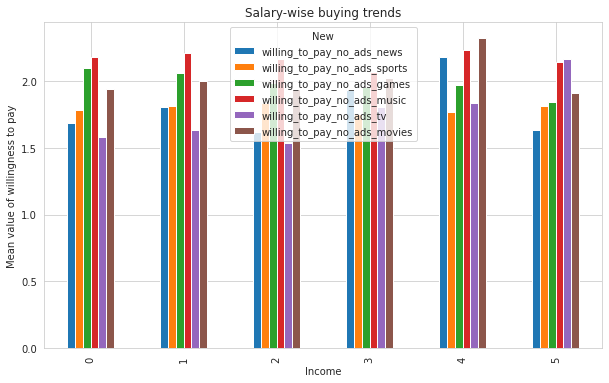

In [ ]:
# Group the data by income and get the mean of the "willing_to_pay" columns
income_group = df_combined.groupby("income")[["willing_to_pay_no_ads_news", "willing_to_pay_no_ads_sports",
                                     "willing_to_pay_no_ads_games", "willing_to_pay_no_ads_music",
                                     "willing_to_pay_no_ads_tv", "willing_to_pay_no_ads_movies"]].mean()

# Plot the mean values for each income group
income_group.plot(kind="bar", figsize=(10,6))
plt.title("Salary-wise buying trends")
plt.xlabel("Income")
plt.ylabel("Mean value of willingness to pay")
plt.show()


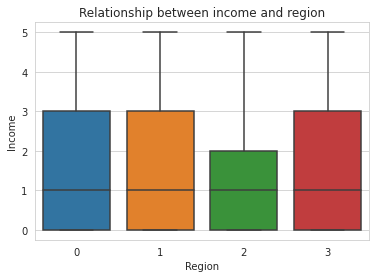

In [ ]:
# Create a boxplot to visualize the relationship between income and region
sns.boxplot(x="region", y="income", data=df_combined)

# Set the title and axes labels
plt.title("Relationship between income and region")
plt.xlabel("Region")
plt.ylabel("Income")

# Show the plot
plt.show()

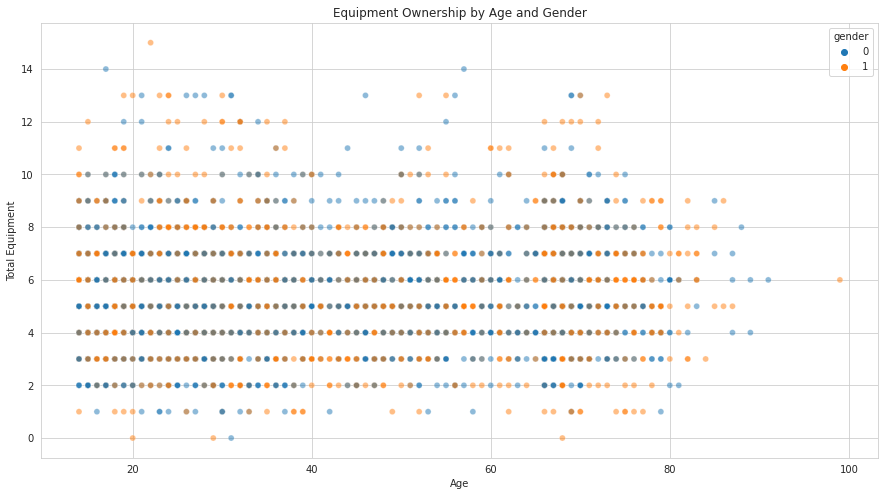

In [ ]:
equipment_cols = ['home_entertainment_equipment_flat_panel_tv', 'home_entertainment_equipment_dvr',
                  'home_entertainment_equipment_streaming_box', 'home_entertainment_equipment_streaming_fob',
                  'home_entertainment_equipment_tv_antenna', 'home_entertainment_equipment_bluray_dvd_player',
                  'home_entertainment_equipment_gaming_console', 'home_entertainment_equipment_portable_game_console',
                  'home_entertainment_equipment_router', 'home_entertainment_equipment_desktop',
                  'home_entertainment_equipment_laptop', 'home_entertainment_equipment_tablet',
                  'home_entertainment_equipment_e-reader', 'home_entertainment_equipment_smartphone',
                  'home_entertainment_equipment_mobile_phone', 'home_entertainment_equipment_smartwatch',
                  'home_entertainment_equipment_fitness_band', 'home_entertainment_equipment_vr_headset',
                  'home_entertainment_equipment_drone', 'home_entertainment_equipment_none',
                  'home_entertainment_equipment_unknown']

# Calculate the total number of equipment each respondent owns
df_combined['total_equipment'] = df_combined[equipment_cols].sum(axis=1)

# Create a scatter plot of equipment ownership vs. age
plt.figure(figsize=(15,8))
sns.scatterplot(data=df_combined, x='age', y='total_equipment', hue='gender', alpha=0.5)
plt.xlabel('Age')
plt.ylabel('Total Equipment')
plt.title('Equipment Ownership by Age and Gender')
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


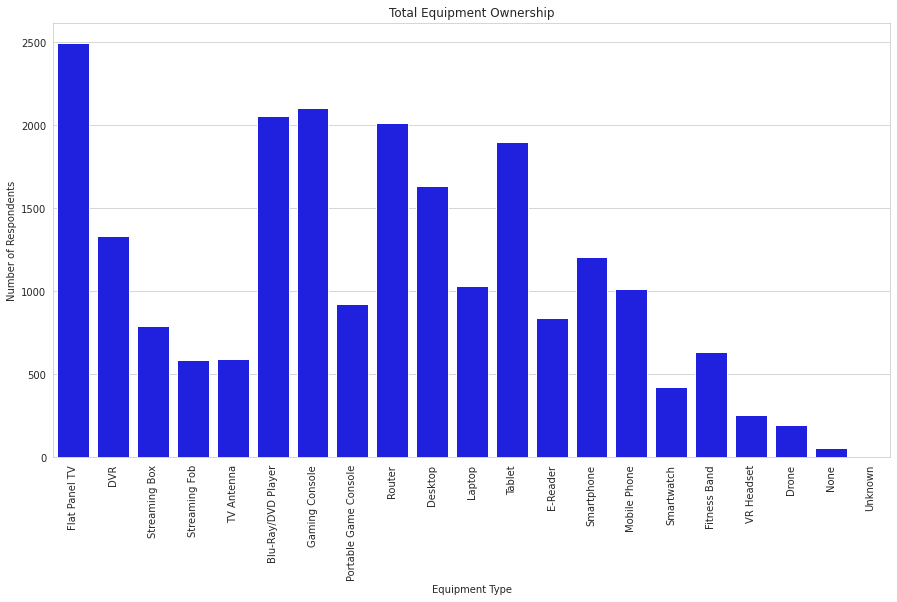

In [ ]:
# Create a bar chart of equipment ownership by category
equipment_cols_display = ['Flat Panel TV', 'DVR', 'Streaming Box', 'Streaming Fob', 'TV Antenna',
                          'Blu-Ray/DVD Player', 'Gaming Console', 'Portable Game Console', 'Router',
                          'Desktop', 'Laptop', 'Tablet', 'E-Reader', 'Smartphone', 'Mobile Phone',
                          'Smartwatch', 'Fitness Band', 'VR Headset', 'Drone', 'None', 'Unknown']
equipment_totals = [df_combined[col].sum() for col in equipment_cols]
plt.figure(figsize=(15,8))
sns.barplot(equipment_cols_display, equipment_totals, color='blue')
plt.xticks(rotation=90)
plt.xlabel('Equipment Type')
plt.ylabel('Number of Respondents')
plt.title('Total Equipment Ownership')
plt.show()

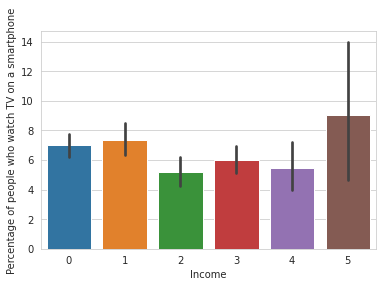

In [ ]:
# Plot the percentage of people in each income group who watch TV on a smartphone
sns.barplot(x='income', y='pct_watch_tv_smartphone', data=df_combined)
plt.xlabel('Income')
plt.ylabel('Percentage of people who watch TV on a smartphone')
plt.show()

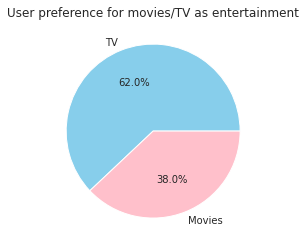

In [ ]:
plt.pie(df_combined['home_entertainment_equipment_flat_panel_tv'].value_counts(), labels=['TV', 'Movies'], colors=['skyblue', 'pink'], autopct='%1.1f%%')

# Add title
plt.title('User preference for movies/TV as entertainment')

# Show the plot
plt.show()

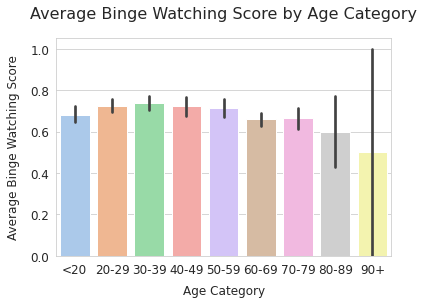

In [ ]:
# Group age groups into categories
df_combined.loc[:, 'age_category'] = pd.cut(df_combined['age'], [0, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                                            labels=['<20', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+'])

# Create a bar plot of the average binge watching score for each age category
sns.barplot(x='age_category', y='binge_watch', data=df_combined, palette='pastel')

# Add labels and title
plt.xlabel('Age Category', fontsize=12, labelpad=8)
plt.ylabel('Average Binge Watching Score', fontsize=12, labelpad=10)
plt.title('Average Binge Watching Score by Age Category', fontsize=16, pad=20)

# Adjust the tick label font size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()


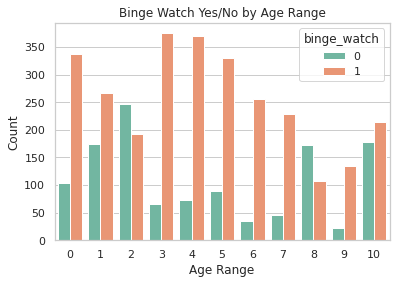

In [ ]:
sns.set(style='whitegrid')

# Create a countplot of the binge_watch variable for each age range
sns.countplot(x='age_range', hue='binge_watch', data=df_combined, palette='Set2')

# Set the title and labels for the plot
plt.title('Binge Watch Yes/No by Age Range')
plt.xlabel('Age Range')
plt.ylabel('Count')

# Show the plot
plt.show()

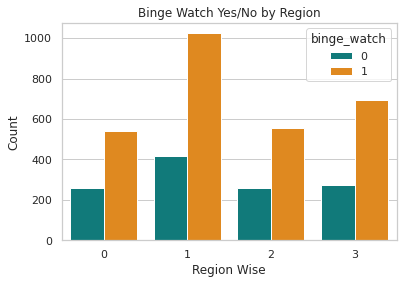

In [ ]:
sns.set(style='whitegrid')
palette = ['#008B8B', '#FF8C00']
# Create a countplot of the binge_watch variable for each age range
sns.countplot(x='region', hue='binge_watch', data=df_combined, palette=palette)

# Set the title and labels for the plot
plt.title('Binge Watch Yes/No by Region')
plt.xlabel('Region Wise')
plt.ylabel('Count')

# Show the plot
plt.show()

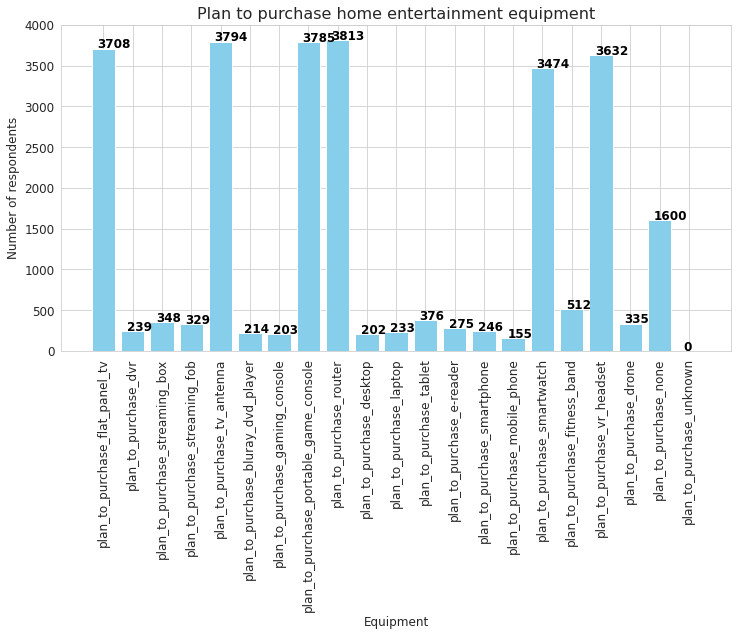

In [ ]:
# create a list of column names
cols = ['plan_to_purchase_flat_panel_tv', 'plan_to_purchase_dvr', 'plan_to_purchase_streaming_box', 'plan_to_purchase_streaming_fob',
        'plan_to_purchase_tv_antenna', 'plan_to_purchase_bluray_dvd_player', 'plan_to_purchase_gaming_console', 'plan_to_purchase_portable_game_console',
        'plan_to_purchase_router', 'plan_to_purchase_desktop', 'plan_to_purchase_laptop', 'plan_to_purchase_tablet', 'plan_to_purchase_e-reader',
        'plan_to_purchase_smartphone', 'plan_to_purchase_mobile_phone', 'plan_to_purchase_smartwatch', 'plan_to_purchase_fitness_band',
        'plan_to_purchase_vr_headset', 'plan_to_purchase_drone', 'plan_to_purchase_none', 'plan_to_purchase_unknown']

# create an empty dictionary to store the sums
results = {}

# loop through each column and calculate the sum of values
for col in cols:
    results[col] = df_combined[col].sum()

# create a bar graph of the results
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(results)), list(results.values()), align='center', color='skyblue')

# beautify the graph
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x()+0.2, yval + 10, str(int(yval)), fontsize=12, fontweight='bold', color='black')

plt.xticks(range(len(results)), list(results.keys()), rotation=90, fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('Equipment', fontsize=12)
plt.ylabel('Number of respondents', fontsize=12)
plt.title('Plan to purchase home entertainment equipment', fontsize=16)
plt.show()



<ipython-input-30-38a8d0ea81df>:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  age_group_totals = df_combined.groupby('age_group')['plan_to_purchase_flat_panel_tv', 'plan_to_purchase_dvr', 'plan_to_purchase_streaming_box',


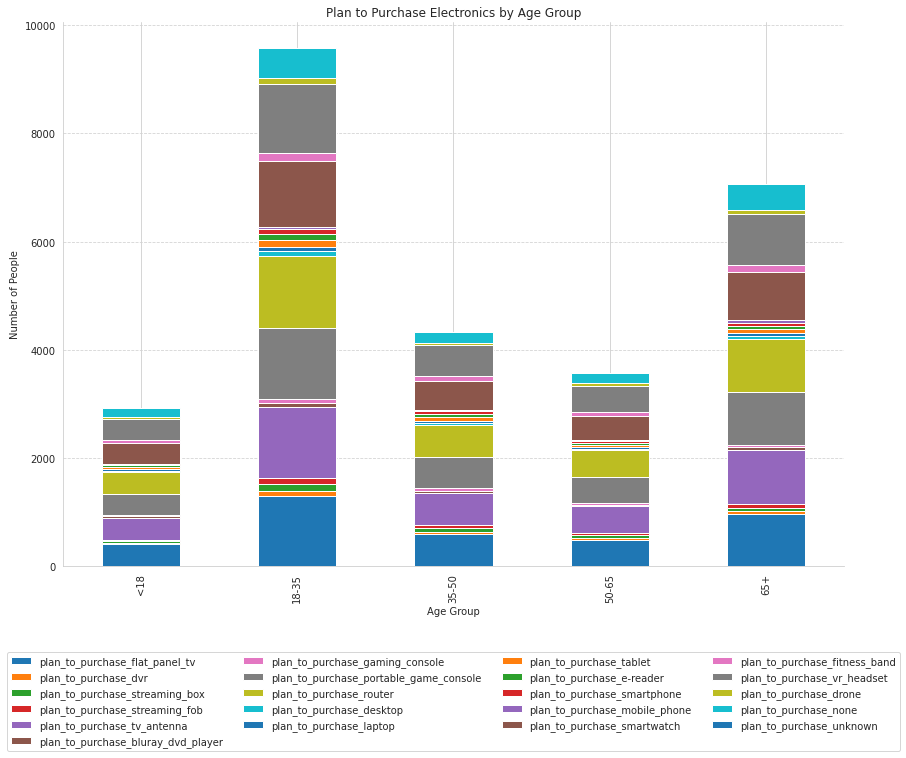

In [ ]:
# convert the age column to a list of integers
age_list = [int(age) for age in df_combined['age']]

# add the age list to the dataframe as a new column
df_combined['age_group'] = pd.cut(age_list, bins=[0, 18, 35, 50, 65, 100], labels=['<18', '18-35', '35-50', '50-65', '65+'])

# group the data by age group and sum the plan_to_purchase columns
age_group_totals = df_combined.groupby('age_group')['plan_to_purchase_flat_panel_tv', 'plan_to_purchase_dvr', 'plan_to_purchase_streaming_box',
                                            'plan_to_purchase_streaming_fob', 'plan_to_purchase_tv_antenna', 'plan_to_purchase_bluray_dvd_player',
                                            'plan_to_purchase_gaming_console', 'plan_to_purchase_portable_game_console', 'plan_to_purchase_router',
                                            'plan_to_purchase_desktop', 'plan_to_purchase_laptop', 'plan_to_purchase_tablet', 'plan_to_purchase_e-reader',
                                            'plan_to_purchase_smartphone', 'plan_to_purchase_mobile_phone', 'plan_to_purchase_smartwatch',
                                            'plan_to_purchase_fitness_band', 'plan_to_purchase_vr_headset', 'plan_to_purchase_drone',
                                            'plan_to_purchase_none', 'plan_to_purchase_unknown'].sum()
# plot the stacked bar chart
ax = age_group_totals.plot(kind='bar', stacked=True, figsize=(14,10))

# add labels and title
plt.xlabel('Age Group')
plt.ylabel('Number of People')
plt.title('Plan to Purchase Electronics by Age Group')

# move the legend below the plot
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)

# beautify the graph
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.grid(color='lightgray', linestyle='dashed')

<ipython-input-31-a31d1b12c027>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  owned_age_group_totals = df_combined.groupby('age_group')['home_entertainment_equipment_flat_panel_tv',


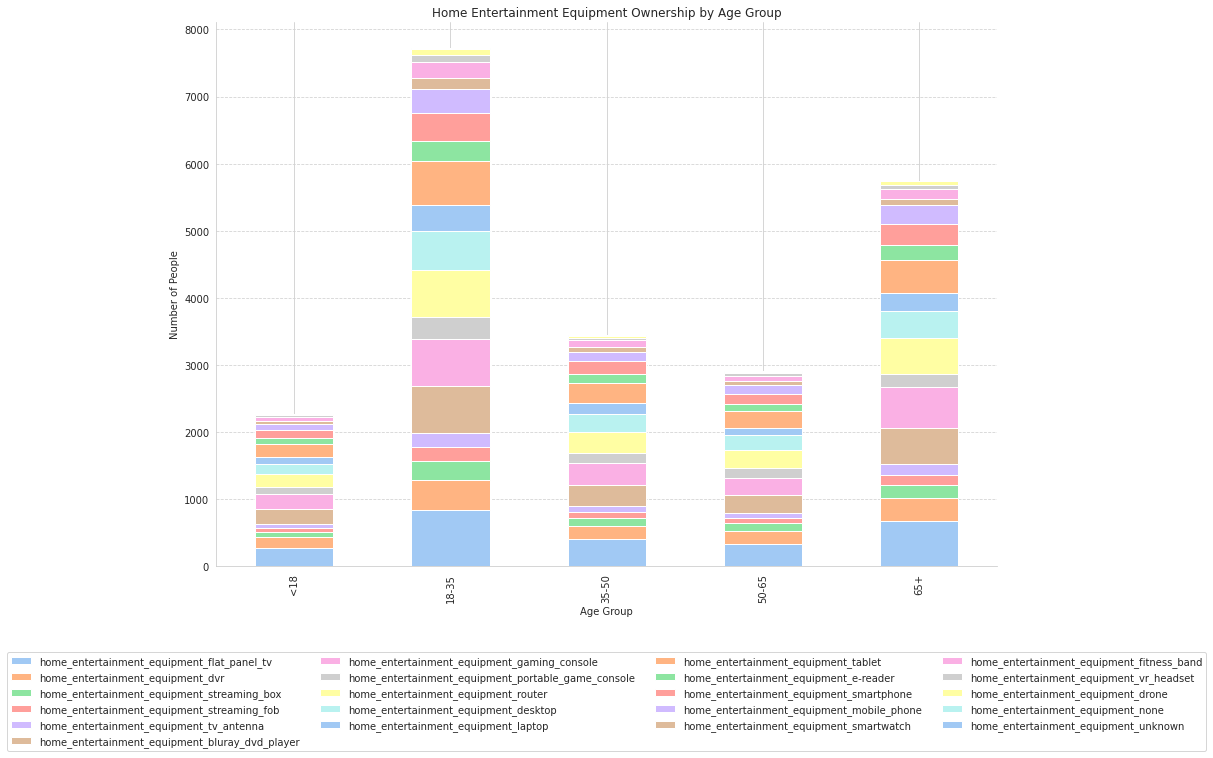

In [ ]:
# group the data by age group and sum the plan_to_purchase columns
owned_age_group_totals = df_combined.groupby('age_group')['home_entertainment_equipment_flat_panel_tv',
           'home_entertainment_equipment_dvr',
           'home_entertainment_equipment_streaming_box',
           'home_entertainment_equipment_streaming_fob',
           'home_entertainment_equipment_tv_antenna',
           'home_entertainment_equipment_bluray_dvd_player',
           'home_entertainment_equipment_gaming_console',
           'home_entertainment_equipment_portable_game_console',
           'home_entertainment_equipment_router',
           'home_entertainment_equipment_desktop',
           'home_entertainment_equipment_laptop',
           'home_entertainment_equipment_tablet',
           'home_entertainment_equipment_e-reader',
           'home_entertainment_equipment_smartphone',
           'home_entertainment_equipment_mobile_phone',
           'home_entertainment_equipment_smartwatch',
           'home_entertainment_equipment_fitness_band',
           'home_entertainment_equipment_vr_headset',
           'home_entertainment_equipment_drone',
           'home_entertainment_equipment_none',
           'home_entertainment_equipment_unknown'].sum()

# set the color palette
colors = sns.color_palette('pastel')

# plot the stacked bar chart with the specified color palette
ax = owned_age_group_totals.plot(kind='bar', stacked=True, figsize=(14,10), color=colors)

# add labels and title
plt.xlabel('Age Group')
plt.ylabel('Number of People')
plt.title('Home Entertainment Equipment Ownership by Age Group')

# move the legend below the plot
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)

# beautify the graph
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.grid(color='lightgray', linestyle='dashed')

<ipython-input-32-42cb4c4105e3>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  pct_age_group_movies = df_combined.groupby('age_group')['pct_watch_movies_smartphone','pct_watch_movies_tablet',


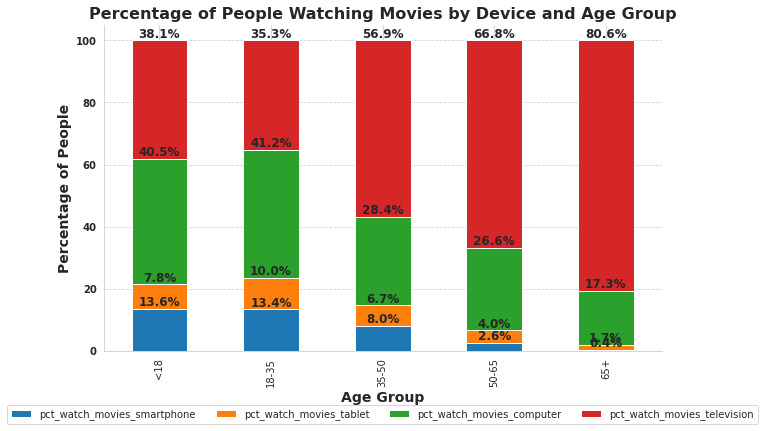

In [ ]:
pct_age_group_movies = df_combined.groupby('age_group')['pct_watch_movies_smartphone','pct_watch_movies_tablet',
           'pct_watch_movies_computer',
           'pct_watch_movies_television'].mean()

# calculate the percentage values
pct_age_group_totals_pct = pct_age_group_movies.apply(lambda x: x/x.sum(), axis=1) * 100


# plot the stacked bar chart
ax = pct_age_group_totals_pct.plot(kind='bar', stacked=True, figsize=(10,6))

# Add percentage labels to each bar
for i in ax.containers:
    ax.bar_label(i, labels=[f"{val:.1f}%" if val > 0 else "" for val in i.datavalues], label_type='edge', fontsize=12, fontweight='bold')

# Add labels and title
plt.xlabel('Age Group', fontsize=14, fontweight='bold')
plt.ylabel('Percentage of People', fontsize=14, fontweight='bold')
plt.title('Percentage of People Watching Movies by Device and Age Group', fontsize=16, fontweight='bold')

# Move the legend below the plot
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)

# Beautify the graph
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.grid(color='lightgray', linestyle='dashed')

# Set y-axis tick labels to bold
plt.yticks(fontweight='bold')

# Show the plot
plt.show()

<ipython-input-33-d31b73f04791>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  pct_age_group_sports = df_combined.groupby('age_group')['pct_watch_sports_smartphone',


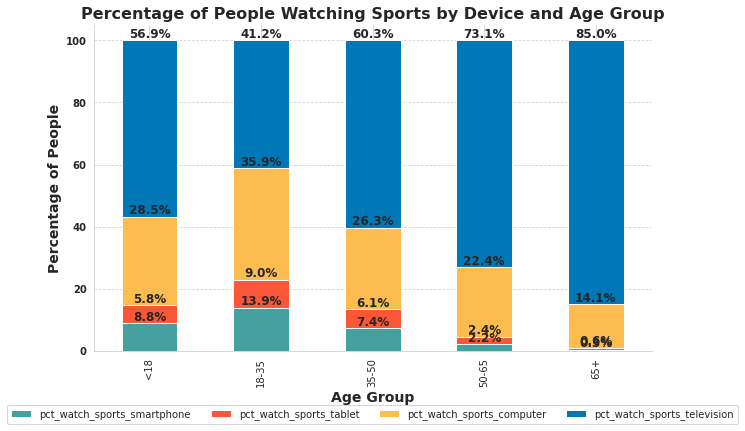

In [ ]:
# Define cool colors
cool_colors = ['#44a1a0', '#f95738', '#fdbc50', '#0077b6']

pct_age_group_sports = df_combined.groupby('age_group')['pct_watch_sports_smartphone',
'pct_watch_sports_tablet',
'pct_watch_sports_computer',
'pct_watch_sports_television'].mean()

pct_age_group_totals_pct = pct_age_group_sports.apply(lambda x: x/x.sum(), axis=1) * 100

# Plot the stacked bar chart
ax = pct_age_group_totals_pct.plot(kind='bar', stacked=True, figsize=(10,6), color=cool_colors)

# Add percentage labels to each bar
for i in ax.containers:
    ax.bar_label(i, labels=[f"{val:.1f}%" if val > 0 else "" for val in i.datavalues], label_type='edge', fontsize=12, fontweight='bold')

# Add labels and title
plt.xlabel('Age Group', fontsize=14, fontweight='bold')
plt.ylabel('Percentage of People', fontsize=14, fontweight='bold')
plt.title('Percentage of People Watching Sports by Device and Age Group', fontsize=16, fontweight='bold')

# Move the legend below the plot
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)

# Beautify the graph
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.grid(color='lightgray', linestyle='dashed')

# Set y-axis tick labels to bold
plt.yticks(fontweight='bold')

# Show the plot
plt.show()

<ipython-input-34-0fa3b0dca1c6>:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  pct_age_group_tv = df_combined.groupby('age_group')['pct_watch_tv_smartphone',


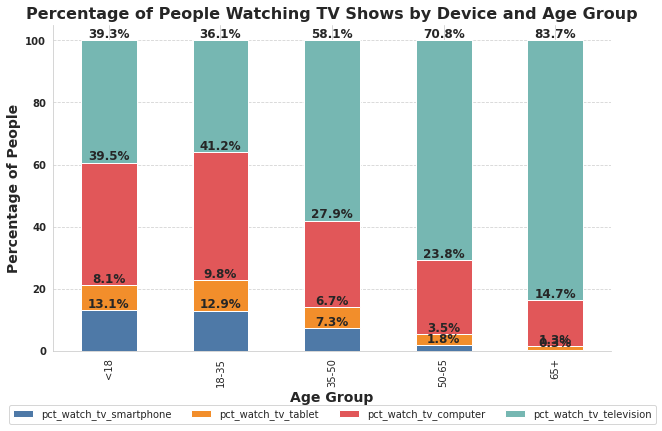

In [ ]:
# Define cool colors
cool_colors = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2']


pct_age_group_tv = df_combined.groupby('age_group')['pct_watch_tv_smartphone',
'pct_watch_tv_tablet',
'pct_watch_tv_computer',
'pct_watch_tv_television'].mean()

pct_age_group_totals_pct = pct_age_group_tv.apply(lambda x: x/x.sum(), axis=1) * 100

# Plot the stacked bar chart
ax = pct_age_group_totals_pct.plot(kind='bar', stacked=True, figsize=(10,6), color=cool_colors)

# Add percentage labels to each bar
for i in ax.containers:
    ax.bar_label(i, labels=[f"{val:.1f}%" if val > 0 else "" for val in i.datavalues], label_type='edge', fontsize=12, fontweight='bold')

# Add labels and title
plt.xlabel('Age Group', fontsize=14, fontweight='bold')
plt.ylabel('Percentage of People', fontsize=14, fontweight='bold')
plt.title('Percentage of People Watching TV Shows by Device and Age Group', fontsize=16, fontweight='bold')

# Move the legend below the plot
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)

# Beautify the graph
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.grid(color='lightgray', linestyle='dashed')

# Set y-axis tick labels to bold
plt.yticks(fontweight='bold')

# Show the plot
plt.show()

<ipython-input-35-338f066776b8>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  pct_region_group_movies = df_combined.groupby('region')['pct_watch_movies_smartphone','pct_watch_movies_tablet',
<ipython-input-35-338f066776b8>:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  pct_region_group_movies = df_combined.groupby('region')['pct_watch_movies_smartphone', 'pct_watch_movies_tablet',


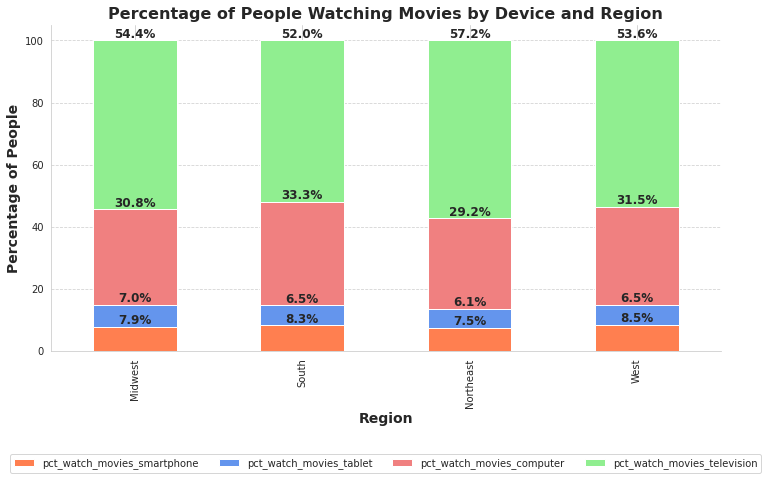

In [ ]:
pct_region_group_movies = df_combined.groupby('region')['pct_watch_movies_smartphone','pct_watch_movies_tablet',
           'pct_watch_movies_computer',
           'pct_watch_movies_television'].mean()

# group by region and calculate the mean percentage for each device
pct_region_group_movies = df_combined.groupby('region')['pct_watch_movies_smartphone', 'pct_watch_movies_tablet',
                                                        'pct_watch_movies_computer', 'pct_watch_movies_television'].mean()

# normalize the percentages so that each row sums up to 100
pct_region_group_movies_pct = pct_region_group_movies.apply(lambda x: x/x.sum(), axis=1) * 100

# define a list of cool colors
bright_colors = ['#FF7F50', '#6495ED', '#F08080', '#90EE90']

# plot the stacked bar chart
ax = pct_region_group_movies_pct.plot(kind='bar', stacked=True, figsize=(12, 6), color=bright_colors)

# add percentage labels to each bar
for i in ax.containers:
    ax.bar_label(i, labels=[f"{val:.1f}%" if val > 0 else "" for val in i.datavalues], label_type='edge', fontsize=12, fontweight='bold')




plt.xlabel('Region', fontsize=14, fontweight='bold')
plt.ylabel('Percentage of People', fontsize=14, fontweight='bold')
plt.title('Percentage of People Watching Movies by Device and Region', fontsize=16, fontweight='bold')
ax.set_xticklabels(['Midwest', 'South', 'Northeast', 'West'])

# move the legend below the plot
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=4)


# beautify the graph
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.grid(color='lightgray', linestyle='dashed')

# display the plot
plt.show()

<ipython-input-36-215b7af144c1>:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  pct_region_group_sports = df_combined.groupby('region')['pct_watch_sports_smartphone',


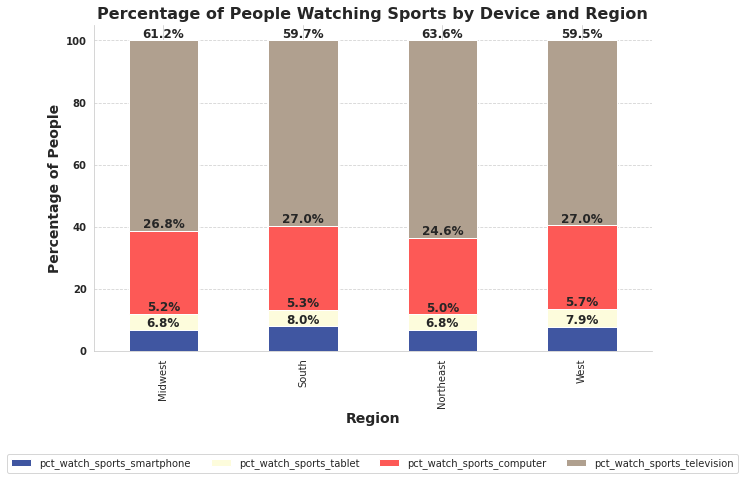

In [ ]:

# Define cool colors
cool_colors = ['#4056A1', '#FDFCDC', '#FD5956', '#B0A08F']

pct_region_group_sports = df_combined.groupby('region')['pct_watch_sports_smartphone',
'pct_watch_sports_tablet',
'pct_watch_sports_computer',
'pct_watch_sports_television'].mean()

pct_region_group_totals_pct = pct_region_group_sports.apply(lambda x: x/x.sum(), axis=1) * 100

# Plot the stacked bar chart
ax = pct_region_group_totals_pct.plot(kind='bar', stacked=True, figsize=(10,6), color=cool_colors)

# Add percentage labels to each bar
for i in ax.containers:
    ax.bar_label(i, labels=[f"{val:.1f}%" if val > 0 else "" for val in i.datavalues], label_type='edge', fontsize=12, fontweight='bold')

# Add labels and title
plt.xlabel('Region', fontsize=14, fontweight='bold')
plt.ylabel('Percentage of People', fontsize=14, fontweight='bold')
plt.title('Percentage of People Watching Sports by Device and Region', fontsize=16, fontweight='bold')
ax.set_xticklabels(['Midwest', 'South', 'Northeast', 'West'])
# Move the legend below the plot
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.3), ncol=4)

# Beautify the graph
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.grid(color='lightgray', linestyle='dashed')

# Set y-axis tick labels to bold
plt.yticks(fontweight='bold')

# Show the plot
plt.show()


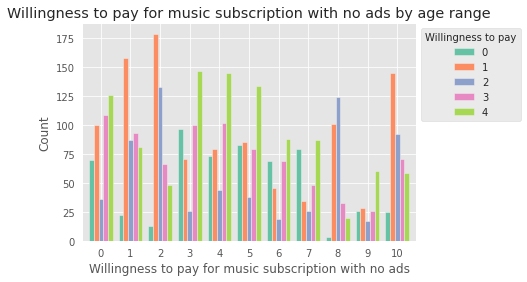

In [ ]:
data = df_combined[['age_range', 'willing_to_pay_no_ads_music']]
data_counts = data.groupby(['age_range', 'willing_to_pay_no_ads_music']).size().reset_index(name='count')

# Pivot the data to create a clustered bar chart
data_pivot = data_counts.pivot(index='age_range', columns='willing_to_pay_no_ads_music', values='count')

# Define the plot style and color map
plt.style.use('ggplot')
cmap = plt.get_cmap('Set2')

# Create the clustered bar chart
ax = data_pivot.plot(kind='bar', width=0.8, color=cmap.colors)

# Add labels and titles
ax.set_xlabel('Willingness to pay for music subscription with no ads')
ax.set_ylabel('Count')
ax.set_title('Willingness to pay for music subscription with no ads by age range')

# Customize the ticks and axis labels
ax.set_xticklabels(data_pivot.index, rotation=0)
ax.legend(title='Willingness to pay', bbox_to_anchor=(1, 1))

# Show the plot
plt.show()

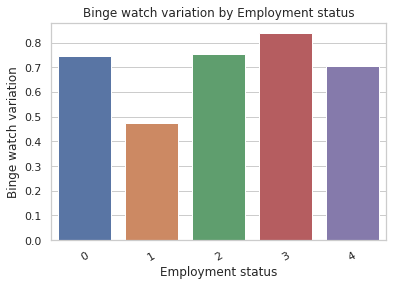

In [ ]:
# calculate the mean media consumption by education level
edu_means = df_combined.groupby('employment_status')['binge_watch'].mean().reset_index()

# create a bar plot of mean media consumption by education level
sns.barplot(x='employment_status', y='binge_watch', data=edu_means)

# set the plot title and axis labels
plt.title('Binge watch variation by Employment status')
plt.xlabel('Employment status')
plt.ylabel('Binge watch variation')
plt.xticks(rotation=30)
# show the plot
plt.show()

# Unsupervised Modelling

## Removing multicollinearity

In [ ]:
# Calculate VIF values for all the features
vif = pd.DataFrame()
vif["features"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Remove columns with VIF greater than a threshold
threshold = 5
high_vif_cols = vif[vif['VIF'] > threshold]['features'].values
df1 = df1.drop(high_vif_cols, axis=1)


/usr/local/lib/python3.8/dist-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


KeyError: ignored

In [ ]:
(high_vif_cols)

array(['age', 'pct_watch_movies_computer', 'pct_watch_movies_television',
       'pct_watch_tv_computer', 'pct_watch_tv_television',
       'plan_to_purchase_flat_panel_tv', 'plan_to_purchase_tv_antenna',
       'plan_to_purchase_portable_game_console',
       'plan_to_purchase_router', 'plan_to_purchase_smartwatch',
       'plan_to_purchase_vr_headset', 'subscriber_gaming',
       'watch_movies_purchase_digital', 'watch_movies_rent_digital',
       'watch_tv_purchase_physical'], dtype=object)

In [ ]:
# Normalize the data using min-max scaling and visualize the distribution again
scaler = MinMaxScaler()
X = scaler.fit_transform(df1)
df1[df1.columns] = X

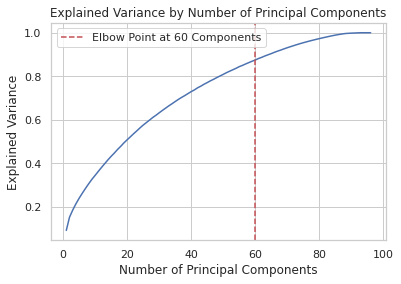

The elbow point is at 60 principal components


In [ ]:
# Calculate explained variance for different number of components
n_components = len(X[0])
variance = []
for n in range(1, n_components+1):
    pca = PCA(n_components=n)
    pca.fit(X)
    variance.append(sum(pca.explained_variance_ratio_))

# Find the elbow point of the plot at first kink at 5
elbow = 60

# Plot the explained variance by number of principal components
plt.plot(range(1, n_components+1), variance)
plt.title('Explained Variance by Number of Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance')
plt.axvline(x=elbow, color='r', linestyle='--', label=f'Elbow Point at {elbow} Components')
plt.legend()
plt.show()

print(f'The elbow point is at {elbow} principal components')



/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: F

Text(0, 0.5, 'SSE')

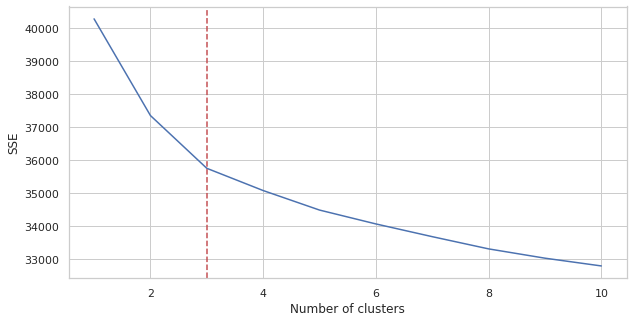

In [ ]:
# Perform PCA with elbow componenents
pca = PCA(n_components=elbow)
principal_components = pca.fit_transform(X)
principal_df = pd.DataFrame(data=principal_components, columns=[f'PC{i}' for i in range(1, elbow+1)])

# Determine optimal number of kmeans clusters using elbow method on PCA'd data
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(principal_df)
    sse[k] = kmeans.inertia_


# Plot SSE for each value of k
plt.figure(figsize=(10, 5))
plt.plot(list(sse.keys()), list(sse.values()))
plt.axvline(x=3, color='r', linestyle='--')
plt.xlabel("Number of clusters")
plt.ylabel("SSE")


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing

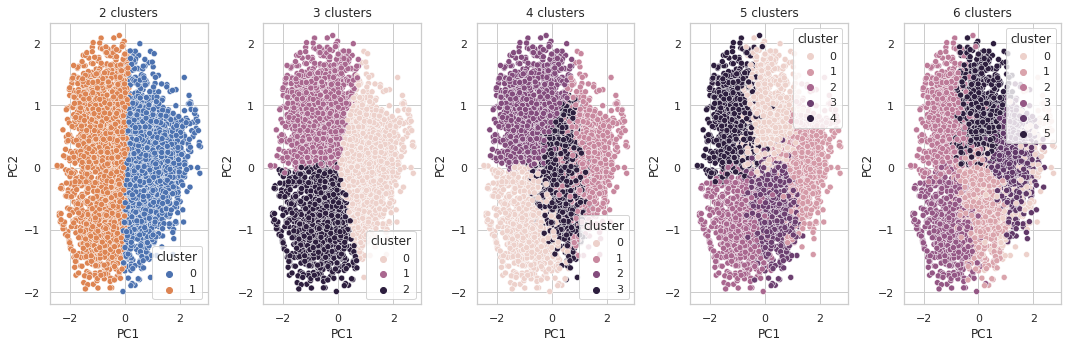

In [ ]:
# Define the range of cluster sizes to try
cluster_range = range(2, 7)

# Set up a grid of plots to display the results side by side
fig, axes = plt.subplots(nrows=1, ncols=len(cluster_range), figsize=(15, 5))

# Loop through each cluster size, fit the KMeans model, and plot the results
for i, n_clusters in enumerate(cluster_range):
    # Fit KMeans with optimal number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(df1)
    labels = kmeans.labels_

    # Create new dataframe with original features and PCA scores
    new_df = pd.concat([df1.reset_index(drop = True), principal_df], axis=1)

    # Add assigned cluster labels
    new_df['cluster'] = labels

    # Plot the data by PCA components
    x_axis = new_df['PC1']
    y_axis = new_df['PC2']
    sns.scatterplot(x_axis, y_axis, hue=new_df['cluster'], ax=axes[i])
    axes[i].set_title(f'{n_clusters} clusters')

# Show the plot
plt.tight_layout()
plt.show()

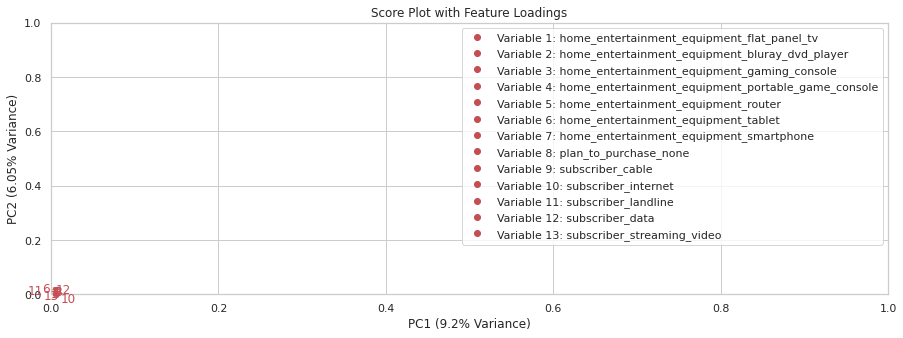

In [ ]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
# Plot feature loadings as vectors on the score plot
features = df1.columns

# plot the PCA graph with higher PC1 contribution as a mandate
fig, ax = plt.subplots(figsize=(15, 5))
significant_features = [feature for i, feature in enumerate(features) if abs(loadings[i, 0]) >= 0.2 or abs(loadings[i, 1]) >= 0.2]

for i, feature in enumerate(significant_features):
    ax.text(loadings[i, 0]*1.15, loadings[i, 1]*1.15, i+1, color='r')

ax.set_xlabel('PC1 ({}% Variance)'.format(round(pca.explained_variance_ratio_[0]*100, 2)))
ax.set_ylabel('PC2 ({}% Variance)'.format(round(pca.explained_variance_ratio_[1]*100, 2)))


ax.set_title(f'Score Plot with Feature Loadings')
ax.set_xlabel('PC1 ({}% Variance)'.format(round(pca.explained_variance_ratio_[0]*100, 2)))
ax.set_ylabel('PC2 ({}% Variance)'.format(round(pca.explained_variance_ratio_[1]*100, 2)))

# Add legend
handles = [plt.Line2D([],[], marker="o", ls="", color='r', label=f"Variable {i+1}: {feature}") for i, feature in enumerate(significant_features)]
ax.legend(handles=handles)

plt.show()


## PCA of each cluster to understand their nature

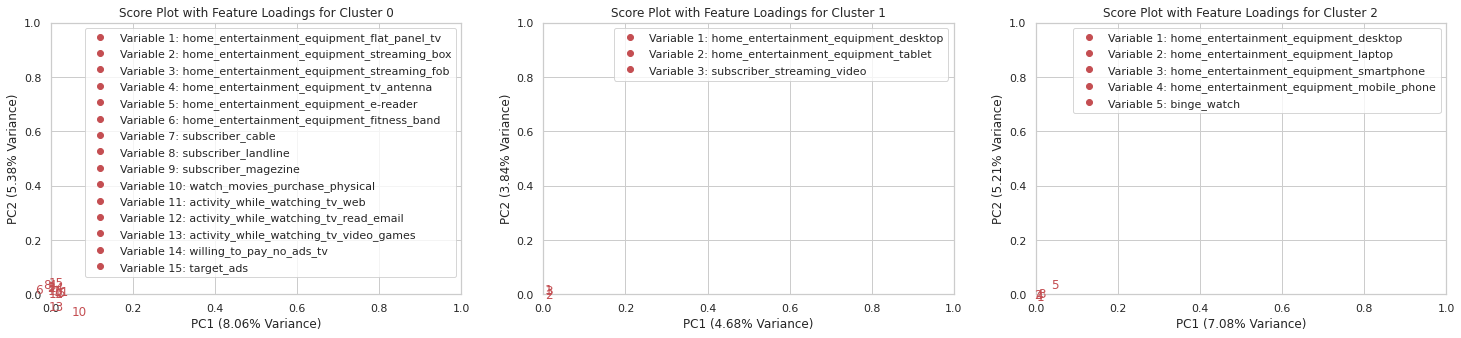

In [ ]:
# Create dictionary of significant features for each cluster
significant_features_dict = {}

# Create score plot with feature loadings for each cluster
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))


for cluster, ax in zip(sorted(new_df['cluster'].unique()), axs.flat):
    cluster_data = new_df[new_df['cluster']==cluster]
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(cluster_data.drop('cluster', axis=1))

    loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
    significant_features = [feature for i, feature in enumerate(features) if abs(loadings[i, 0]) >= 0.2 or abs(loadings[i, 1]) >= 0.2]
    significant_features_dict[cluster] = significant_features

    for i, feature in enumerate(significant_features):
        ax.text(loadings[i, 0]*1.15, loadings[i, 1]*1.15, i+1, color='r')

    ax.set_title(f'Score Plot with Feature Loadings for Cluster {cluster}')
    ax.set_xlabel('PC1 ({}% Variance)'.format(round(pca.explained_variance_ratio_[0]*100, 2)))
    ax.set_ylabel('PC2 ({}% Variance)'.format(round(pca.explained_variance_ratio_[1]*100, 2)))

    # Add legend
    handles = [plt.Line2D([],[], marker="o", ls="", color='r', label=f"Variable {i+1}: {feature}") for i, feature in enumerate(significant_features)]
    ax.legend(handles=handles)



plt.show()

# Supervised Modelling

## Modeling the likelihood of any subscription

In [ ]:
# suppress ConvergenceWarning
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)

importances_dict = {}

for col in df1.filter(like="subscriber").columns[~(df1.filter(like="subscriber").columns.str.endswith("_unknown") | df1.filter(like="subscriber").columns.str.endswith("_none"))]:
    # Define target variable and features
    y = df1[col]
    X = df1.drop([col, 'subscriber_none', 'subscriber_unknown'], axis=1)

    # Perform SMOTE to balance the data
    if len(set(y)) > 1 : # check if y and col have more than one class
        smote = SMOTE()
        X_smote, y_smote = smote.fit_resample(X, y)
    else:
        X_smote, y_smote = X, y

    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.3, random_state=42)

    # Fit logistic regression model with cross-validation
    model = LogisticRegression()
    scores = cross_val_score(model, X_train, y_train, cv=5).max()

    # Make predictions on test set
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluate model performance
    accuracy = model.score(X_test, y_test)
    print(f"Cross-validation scores for {col} : {scores}")

    # Get feature importances
    importances = dict(zip(X_train.columns, model.coef_[0]))

    # Keep only top 20 predictors and calculate R2 score
    top_20_predictors = dict(sorted(importances.items(), key=lambda x: abs(x[1]), reverse=True)[:20])
    importances_dict[col] = top_20_predictors
    X_train_top20 = X_train[list(top_20_predictors.keys())]
    X_test_top20 = X_test[list(top_20_predictors.keys())]
    model_top20 = LinearRegression()
    model_top20.fit(X_train_top20, y_train)
    r2 = model_top20.score(X_test_top20, y_test)
    print(f"R2 for top 10 predictors of {col}: {r2} \n")


Cross-validation scores for subscriber_cable : 0.7591240875912408
R2 for top 10 predictors of subscriber_cable: 0.29478953390000096 

Cross-validation scores for subscriber_internet : 0.7884393063583816
R2 for top 10 predictors of subscriber_internet: 0.3116570858431691 

Cross-validation scores for subscriber_landline : 0.71334431630972
R2 for top 10 predictors of subscriber_landline: 0.211404043239258 

Cross-validation scores for subscriber_voice : 0.6765734265734266
R2 for top 10 predictors of subscriber_voice: 0.12633197066032986 

Cross-validation scores for subscriber_data : 0.7294938917975567
R2 for top 10 predictors of subscriber_data: 0.22980153009585003 

Cross-validation scores for subscriber_streaming_video : 0.7861842105263158
R2 for top 10 predictors of subscriber_streaming_video: 0.3880104409259698 

Cross-validation scores for subscriber_streaming_music : 0.755331088664422
R2 for top 10 predictors of subscriber_streaming_music: 0.2517949611931922 

Cross-validation sco

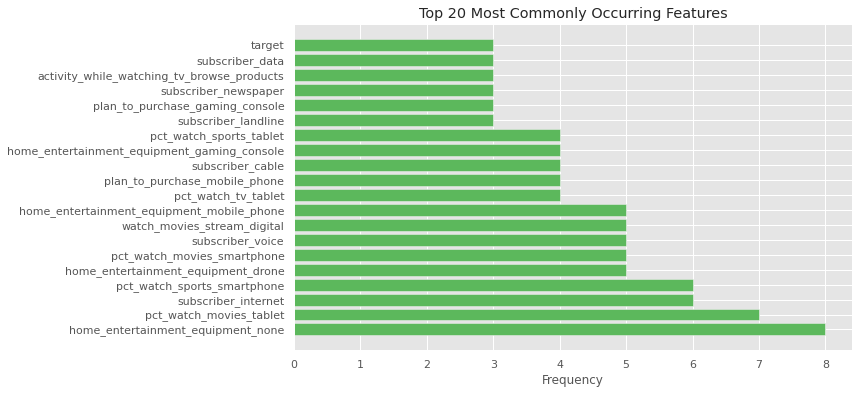

In [ ]:
# Initialize a dictionary to store the feature frequencies
feature_freq = {}

# Iterate through the importances_dict and count the number of keys that contain each feature
for col, feature_dict in importances_dict.items():
    for feature in feature_dict.keys():
        if feature in feature_freq:
            feature_freq[feature] += 1
        else:
            feature_freq[feature] = 1

# Sort the features by frequency and keep only the top 20
sorted_features = sorted(feature_freq.items(), key=lambda x: x[1], reverse=True)[:20]
features = [feature[0] for feature in sorted_features]
frequencies = [feature[1] for feature in sorted_features]

# Set the plot style and size
plt.style.use('ggplot')
plt.figure(figsize=(10, 6))

# Create the bar chart
plt.barh(features, frequencies, color='#5cb85c')

# Add labels and title
plt.xlabel('Frequency')
plt.title('Top 20 Most Commonly Occurring Features')

# Show the plot
plt.show()


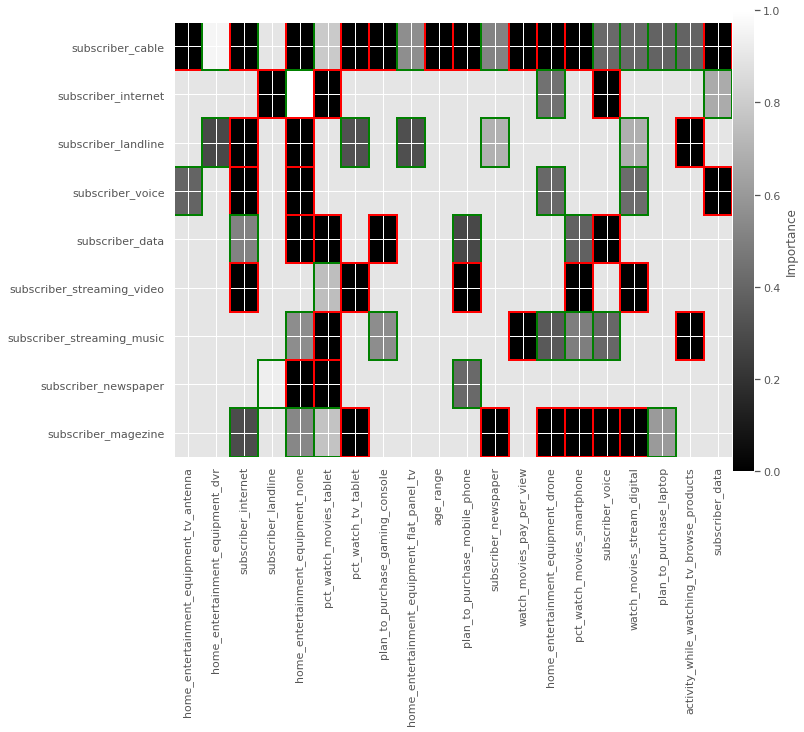

In [ ]:
# Define the features and keys
features = list(importances_dict.keys())
keys = list(importances_dict[features[0]].keys())

# Create a matrix to store the checkbox values
matrix = np.array([[importances_dict[feature].get(key, np.nan) for key in keys] for feature in features])

# Set up the plot
fig, ax = plt.subplots(figsize=(10,8))

# Create the checkbox plot
cb = ax.imshow(matrix, cmap='gray', aspect='auto', vmin=0, vmax=1)

# Add labels and ticks
ax.set_yticks(range(len(features)))
ax.set_yticklabels(features)
ax.set_xticks(range(len(keys)))
ax.set_xticklabels(keys, rotation=90)

# Set the checkbox colors based on the values
for i in range(len(features)):
    for j in range(len(keys)):
        if not np.isnan(matrix[i,j]):
            color = 'green' if matrix[i,j] > 0 else 'red'
            ax.add_patch(plt.Rectangle((j-0.5,i-0.5), 1, 1, fill=False, edgecolor=color, lw=2))

# Add a colorbar legend
cbaxes = fig.add_axes([0.9, 0.1, 0.03, 0.8])
cbar = plt.colorbar(cb, cax=cbaxes)
cbar.ax.set_ylabel('Importance')

# Show the plot
plt.show()


## Modeling the likelihood of Binging habits

In [ ]:
df_temp = df2[['binge_watch','age_range', 'income', 'ethnicity', 'region', 'employment_status',
             'home_entertainment_equipment_flat_panel_tv', 'home_entertainment_equipment_dvr',
             'home_entertainment_equipment_streaming_box', 'home_entertainment_equipment_streaming_fob',
             'home_entertainment_equipment_bluray_dvd_player', 'home_entertainment_equipment_desktop',
             'home_entertainment_equipment_laptop', 'home_entertainment_equipment_tablet',
             'home_entertainment_equipment_smartphone','subscriber_cable', 'subscriber_internet',
             'subscriber_data']]
df_dumm = pd.get_dummies(df_temp, columns=['age_range', 'income', 'ethnicity', 'region', 'employment_status'])
X = df_dumm.drop(['binge_watch'],axis = 'columns')
y = df_dumm['binge_watch']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 74.50%


Random Forest Classifier Accuracy: 72.64%


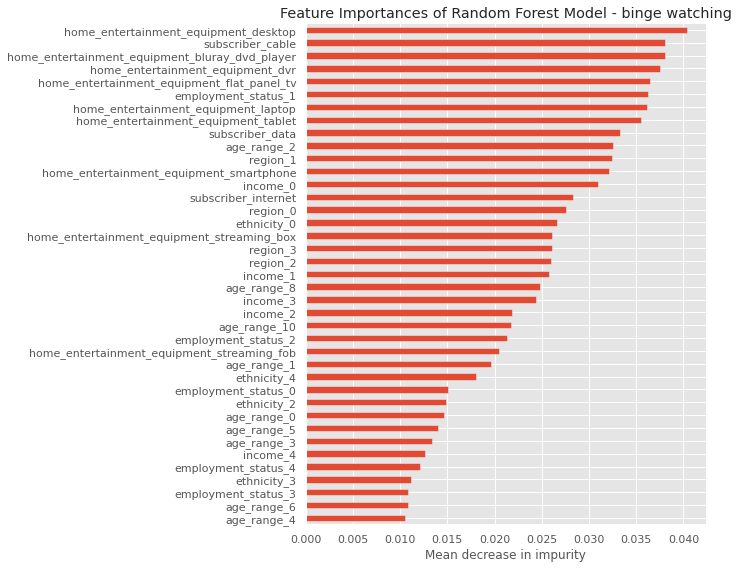

In [ ]:
# Create a Random Forest classifier
rfc = RandomForestClassifier(n_estimators=100, random_state=0)

# Fit the Random Forest classifier to the training data
rfc.fit(X_train, y_train)

# Evaluate the Random Forest classifier on the test data
rfc_acc = rfc.score(X_test, y_test)
print(f"Random Forest Classifier Accuracy: {rfc_acc:.2%}")

def plot_importance(feature_importance, suffix):
    fig, ax = plt.subplots(figsize=(10, 8))
    feature_importance[feature_importance > 0.01].sort_values().plot.barh(ax=ax)
    ax.set_title("Feature Importances of Random Forest Model - {}".format(suffix))
    ax.set_xlabel("Mean decrease in impurity")
    fig.tight_layout()
    plt.show()


feature_names = X.columns
feature_importance_b = pd.Series(rfc.feature_importances_, index=feature_names)
plot_importance(feature_importance_b, "binge watching")

In [ ]:

df4 = df2[['age_range', 'income', 'ethnicity', 'region', 'employment_status','subscriber_streaming_video',
           'watch_tv_stream_digital', 'watch_tv_pay_per_view', 'binge_watch', 'willing_to_pay_no_ads_movies']]

df_temp2 = pd.get_dummies(df4, columns=['age_range', 'income', 'ethnicity', 'region', 'employment_status',
                                       'subscriber_streaming_video', 'watch_tv_stream_digital', 'watch_tv_pay_per_view'])
# Define the predictor variables and target variable
X1 = df_temp2.drop(['willing_to_pay_no_ads_movies'],axis = 'columns')
y1 = df_temp2['willing_to_pay_no_ads_movies']
# Split the data into training and testing set
X1_train, X1_test, y1_train, y1_test = train_test_split(X1,y1, test_size=0.2,random_state = 0)

# Build a logistic regression model
logreg = LogisticRegression(C = 10000, penalty = 'l2')
logreg.fit(X1_train, y1_train)

y_pred_logreg = logreg.predict(X1_test)
#print(y_pred)

# Evaluate the model's accuracy on the testing set
accuracy_logreg = accuracy_score(y1_test, y_pred_logreg)
print("Accuracy: {:.2f}%".format(accuracy_logreg*100))

Accuracy: 35.95%


Random Forest Classifier Accuracy: 32.96%


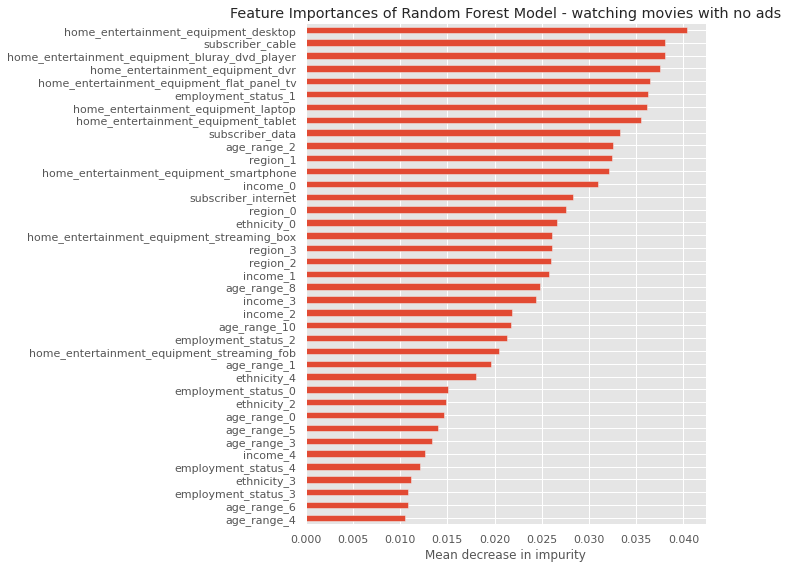

In [ ]:
# Create a Random Forest classifier
rfc2 = RandomForestClassifier(n_estimators=100, random_state=0)

# Fit the Random Forest classifier to the training data
rfc2.fit(X1_train, y1_train)

# Make predictions on the test data
y_pred_rfc2 = rfc2.predict(X1_test)

# Evaluate the model's accuracy
accuracy_rfc2 = accuracy_score(y1_test, y_pred_rfc2)
print("Random Forest Classifier Accuracy: {:.2f}%".format(accuracy_rfc2*100))

feature_names_a = X.columns
feature_importance_a = pd.Series(rfc.feature_importances_, index=feature_names_a)
plot_importance(feature_importance_a, "watching movies with no ads")